In [2]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import numpy as np
!pip install tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score

In [5]:
#os.chdir("/Users/michelkauffmann/Downloads")
u = loadmat('u_F_xyz_T1.mat')["u_F"]
v = loadmat('v_F_xyz_T1.mat')["v_F"]
w = loadmat('w_F_xyz_T1.mat')["w_F"]
tau_11 = loadmat('tau11_xyz_T1.mat')["tau11"]
tau_12 = loadmat('tau12_xyz_T1.mat')["tau12"]
tau_13 = loadmat('tau13_xyz_T1.mat')["tau13"]
tau_22 = loadmat('tau22_xyz_T1.mat')["tau22"]
tau_23 = loadmat('tau23_xyz_T1.mat')["tau23"]
tau_33 = loadmat('tau33_xyz_T1.mat')["tau33"]
tke = loadmat("TKE_F_xyz_T1.mat")["TKE_F"]

In [6]:
u.shape == v.shape == w.shape == tau_11.shape == tke.shape

True

In [7]:
tau_11.shape

(146, 96, 75)

### Create Dataset with TKE

In [8]:
x = np.array([u, v, w, tke])
x = np.transpose(x, [1, 2, 3, 0])

x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)
sample = []
size = 3
y_tau_11 = []
y_tau_12 = []
y_tau_13 = []
y_tau_22 = []
y_tau_23 = []
y_tau_33 = []
for i in tqdm_notebook(range(size, x.shape[0] - size)):
    for j in range(size, x.shape[1] - size):
        for k in range(size, x.shape[2] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            y_tau_11.append(tau_11[i - size][j - size][k - size])
            y_tau_12.append(tau_12[i - size][j - size][k - size])
            y_tau_13.append(tau_13[i - size][j - size][k - size])
            y_tau_22.append(tau_22[i - size][j - size][k - size])
            y_tau_23.append(tau_23[i - size][j - size][k - size])
            y_tau_33.append(tau_33[i - size][j - size][k - size])

In [9]:
x = np.stack(sample, axis = 0)
print(x.shape)
y_tau_11 = np.array(y_tau_11)
y_tau_12 = np.array(y_tau_12)
y_tau_13 = np.array(y_tau_13)
y_tau_22 = np.array(y_tau_22)
y_tau_23 = np.array(y_tau_23)
y_tau_33 = np.array(y_tau_33)

mask =  np.random.rand(x.shape[0]) < 0.80
x_train_1, x_test_1 = x[mask,:,:,:,:], x[~mask,:,:,:,:]

y_train_tau_11, y_test_tau_11 = y_tau_11[mask], y_tau_11[~mask]
y_train_tau_12, y_test_tau_12 = y_tau_12[mask], y_tau_12[~mask]
y_train_tau_13, y_test_tau_13 = y_tau_13[mask], y_tau_13[~mask]
y_train_tau_22, y_test_tau_22 = y_tau_22[mask], y_tau_22[~mask]
y_train_tau_23, y_test_tau_23 = y_tau_23[mask], y_tau_23[~mask]
y_train_tau_33, y_test_tau_33 = y_tau_33[mask], y_tau_33[~mask]

(1051200, 7, 7, 7, 4)


### Create Dataset without TKE

In [10]:
x_train_2 = np.delete(x_train_1, 3, 4)
x_test_2 = np.delete(x_test_1, 3, 4)
print(x_train_2.shape)
print(x_test_2.shape)

(841526, 7, 7, 7, 3)
(209674, 7, 7, 7, 3)


### Create Model Class 

In [17]:
class RNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, filter_size, val_split):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.filter = filter_size
        self.val_split = val_split
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Conv3D(32,
                             kernel_size =  self.filter,
                             activation = self.activation,
                             input_shape = input_shape,   
                             padding = "same",
                             kernel_regularizer = self.regularizer),
            tf.keras.layers.MaxPooling3D(pool_size = (2,2,2)),
            tf.keras.layers.Conv3D(64, 
                             kernel_size =  self.filter, 
                             activation = self.activation,
                             padding = "same",
                             kernel_regularizer = self.regularizer),
            tf.keras.layers.MaxPooling3D(pool_size = (2,2,2)),
            tf.keras.layers.Conv3D(64, 
                             kernel_size =  self.filter, 
                             activation = self.activation,
                             padding = "same",
                             kernel_regularizer = self.regularizer),
            tf.keras.layers.MaxPooling3D(pool_size = (1,1,1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
              #metrics = ['mse'])
        
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
                    #callbacks = [self.callbacks()])
        
        return history, model

###  Compare input with TKE and without TKE

R^2: 0.6097

Correlation: 0.7918

R^2: 0.4979

Correlation: 0.7723



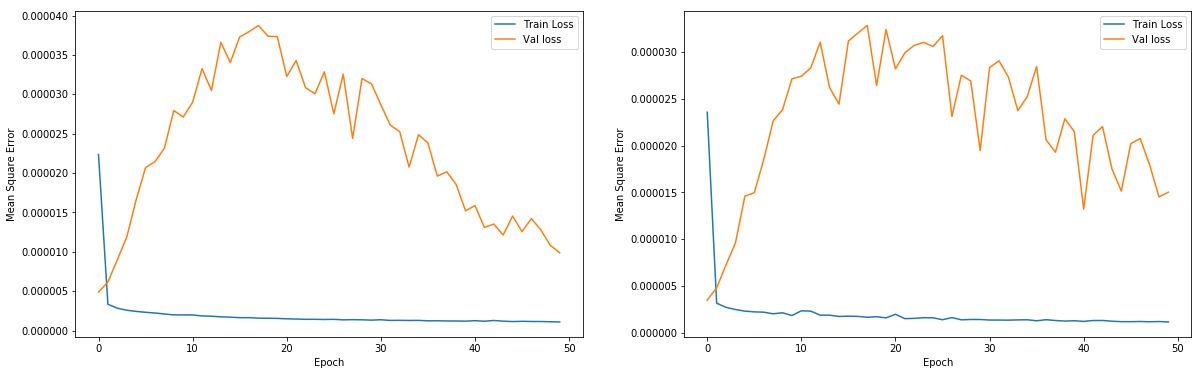

In [19]:
activation = tf.nn.relu
initializer = "glorot_uniform_initializer"
regularizer = None
epochs = 50
batch_size = 10000
filter_size = (3,3,3)
val_split = 0.2

datasets = [(x_train_1, x_test_1), (x_train_2, x_test_2)]
fig = plt.figure(figsize = (20, 6))

i = 1
for (x_train, x_test) in datasets:
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
    model = RNN(activation, initializer, regularizer, x_train, y_train_tau_11, epochs, batch_size, input_shape, filter_size, val_split)
    history, model = model.run_model()
    fig.add_subplot(1, len(datasets), i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    
    y_pred = model.predict(x_test).flatten()
    y_true = y_test_tau_11
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
    i += 1

plt.show()

### Model all 6 Tau's

In [ ]:
activation = tf.nn.relu
initializer = "glorot_uniform_initializer"
regularizer = None
epochs = 50
batch_size = 10000
input_shape = (x.shape[1], x.shape[2], x.shape[3], x.shape[4])
filter_size = (3,3,3)
val_split = 0.2

taus = [(y_train_tau_11, y_test_tau_11), 
            (y_train_tau_12, y_test_tau_12),
            (y_train_tau_13, y_test_tau_13),
            (y_train_tau_22, y_test_tau_22 ),
            (y_train_tau_23, y_test_tau_23 ),
            (y_train_tau_33, y_test_tau_33)]
fig = plt.figure(figsize = (20, 6))

i = 1
for (y_train, y_test) in taus:
    model = RNN(activation, initializer, regularizer, x_train_1, y_train, epochs, batch_size, input_shape, filter_size, val_split)
    history, model = model.run_model()
    fig.add_subplot(1, len(taus), i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    
    y_pred = model.predict(x_test).flatten()
    y_true = y_test
    print("R^2: %.4f\n" % r2_score(y_true, y_pred))
    print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
    i += 1

plt.show()